# LeSimpson

## Intro

This proyect aims to train a CNN model for image prediction on Simpsons Characters.
Steps to reproduce the notebook:

- Download requirements: `pip install -r requirements`
- Set Kaggle account in `~/.kaggle/kaggle.json`
- Start notebook: `jupyter notebook LeSimpson.ipynb`

#### Setup imports and path

In [1]:
import os
import sys

source_path = os.getcwd() + 'source'
if not source_path in sys.path:
    sys.path.append(source_path)


In [2]:
# LOCALS
from source.constants import *
import source.dataviz as dv
import source.dataset as ds
import source.stats as st
from source.model import create_model

import matplotlib.pyplot as plt

Using TensorFlow backend.


## Load and Pre-Process Dataset

First, we need to load the dataset from Kaggle. Then we need to clean a little bit this images, some of the labels do not have enough data to train our model, others have too many and we need to train our model with a nice data quality.

### Download and unzip Dataset (if necessary)

In [3]:
if not (os.path.isdir(DATASET_PATH)):
    from kaggle.api.kaggle_api_extended import KaggleApi
    
    api = KaggleApi()
    api.authenticate()
    api.dataset_download_files("alexattia/the-simpsons-characters-dataset")
    
    !!unzip the-simpsons-characters-dataset.zip -d the-simpsons-characters-dataset

### Define labels

In [4]:
LABELS = os.listdir(TRAINSET_PATH)
LABELS.remove('simpsons_dataset')
print(LABELS)

['maggie_simpson', 'charles_montgomery_burns', 'patty_bouvier', 'ralph_wiggum', 'chief_wiggum', 'milhouse_van_houten', 'rainier_wolfcastle', 'cletus_spuckler', 'martin_prince', 'lenny_leonard', 'sideshow_bob', 'fat_tony', 'selma_bouvier', 'barney_gumble', 'lionel_hutz', 'gil', 'moe_szyslak', 'carl_carlson', 'edna_krabappel', 'snake_jailbird', 'groundskeeper_willie', 'sideshow_mel', 'ned_flanders', 'abraham_grampa_simpson', 'krusty_the_clown', 'waylon_smithers', 'apu_nahasapeemapetilon', 'marge_simpson', 'comic_book_guy', 'nelson_muntz', 'mayor_quimby', 'kent_brockman', 'professor_john_frink', 'principal_skinner', 'bart_simpson', 'lisa_simpson', 'otto_mann', 'troy_mcclure', 'miss_hoover', 'disco_stu', 'homer_simpson', 'agnes_skinner']


### Get stats from our Dataset

We need to learn some stats from the Dataset we have, to be able to clean the data and get fresh for the model.


STATS:
    [Mean] -> 498.4047619047619
    [Std Deviation] -> 570.2569621095977
    [Q1] -> 49.0
    [Q3] -> 967.75



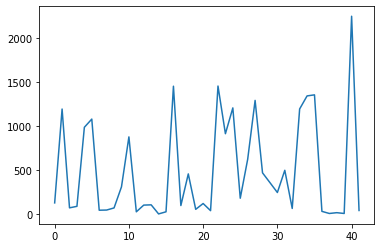

In [5]:
mean, sd, q1, q3 = st.get_stats(LABELS)

### Stats analisis

As we can see, we have a very high standard deviation in terms of *image count per label*, this will produce bad results with our data (overfitting for example).

In order to clean our dataset and make it more fit for our model, we need to reduce the labels that have too much images, and the ones that don't have enough.

### Remove extra labels

First we need to look at the IQR (interquartile range): Q3 - Q1.

With this information we can detect the anomalous labels, those who have below `Q1 - 1.5 * IQR` or above `Q3 + 1.5 * IQR`.

Those who have below, will be removed as labels. And from those who have above, we will remove random image labels until we reach an acceptable
number.

In [6]:
iqr = q3 - q1
low_threshold = q1 - (1.5 * iqr)
upper_threshold = q3 + (1.5 * iqr)

print(f"""
Q1: {q1}
Q3: {q3}
IQR: {iqr}
Low threshold: {low_threshold}
Upper threshold: {upper_threshold}
""")


Q1: 49.0
Q3: 967.75
IQR: 918.75
Low threshold: -1329.125
Upper threshold: 2345.875



As we can see, our lower threshold is negative. In order to mantain a simpler data, we will use as thresholds our quantiles directly (Q1 and Q3).

In [7]:
low_threshold = q1
upper_threshold = q3

#### Remove below & above

In [8]:
count, labels = st.clean_dataset(low_threshold, upper_threshold, LABELS)

removing: rainier_wolfcastle
removing: cletus_spuckler
removing: fat_tony
removing: lionel_hutz
removing: gil
removing: sideshow_mel
removing: otto_mann
removing: troy_mcclure
removing: miss_hoover
removing: disco_stu
removing: agnes_skinner


In [9]:
print(len(count), len(labels))

31 31


### Load full dataset

In order to feed our model with this dataset, we need an image matrix (an array of images for every label) and an array connecting the indexes from the matrix with the actual label.

In [10]:
_labels, _images = ds.build_dataset(labels, count)
X_train, y_train, X_val, y_val = ds.split_train_val(_images, _labels)
X_train_n, y_train_n, X_val_n, y_val_n = ds.normalize(X_train, y_train, X_val, y_val)

### Test loaded dataset

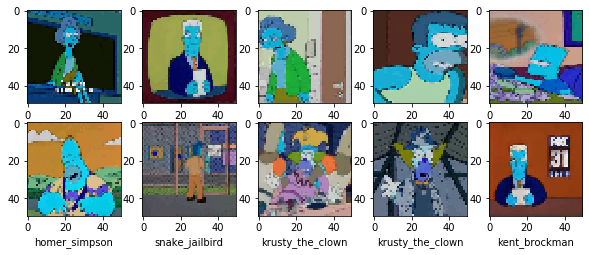

In [11]:
dv.implotr(X_train_n, y_train, labels, 10)

### Create & Compile the model

In [14]:
model = create_model(input_shape=X_train_n.shape[1:], class_num=len(labels))

In [15]:
epochs = 25
optimizer = 'adam'

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

### Train the model!

In [16]:
model.fit(X_train_n, y_train_n, validation_data=(X_val_n, y_val_n), epochs=epochs, batch_size=64)

Train on 14830 samples, validate on 1647 samples
Epoch 1/25
14830/14830 [==============================] - 116s 8ms/step - loss: 2.4715 - accuracy: 0.3594 - val_loss: 3.2223 - val_accuracy: 0.1050
Epoch 2/25
14830/14830 [==============================] - 114s 8ms/step - loss: 1.6056 - accuracy: 0.5599 - val_loss: 2.6772 - val_accuracy: 0.2605
Epoch 3/25
14830/14830 [==============================] - 116s 8ms/step - loss: 1.2424 - accuracy: 0.6534 - val_loss: 1.4176 - val_accuracy: 0.6060
Epoch 4/25
14830/14830 [==============================] - 113s 8ms/step - loss: 0.9706 - accuracy: 0.7246 - val_loss: 1.0859 - val_accuracy: 0.6958
Epoch 5/25
14830/14830 [==============================] - 111s 8ms/step - loss: 0.7533 - accuracy: 0.7815 - val_loss: 0.7852 - val_accuracy: 0.7851
Epoch 6/25
14830/14830 [==============================] - 112s 8ms/step - loss: 0.6087 - accuracy: 0.8236 - val_loss: 0.8685 - val_accuracy: 0.7505
Epoch 7/25
14830/14830 [==============================] - 111s 

### Model evaluation and saving!

In [19]:
model.save('lesimpson.h5')